In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.autograd as autograd
import torch.optim as optim
from torch.optim import Adam
#!pip install torchviz
from torchviz import make_dot

from collections import Counter
import numpy as np

import os

import matplotlib.pyplot as plt
#!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=True)

print("CUDA available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("PyTorch version: ", torch.__version__ )

CUDA available:  True
PyTorch version:  2.2.1+cu121


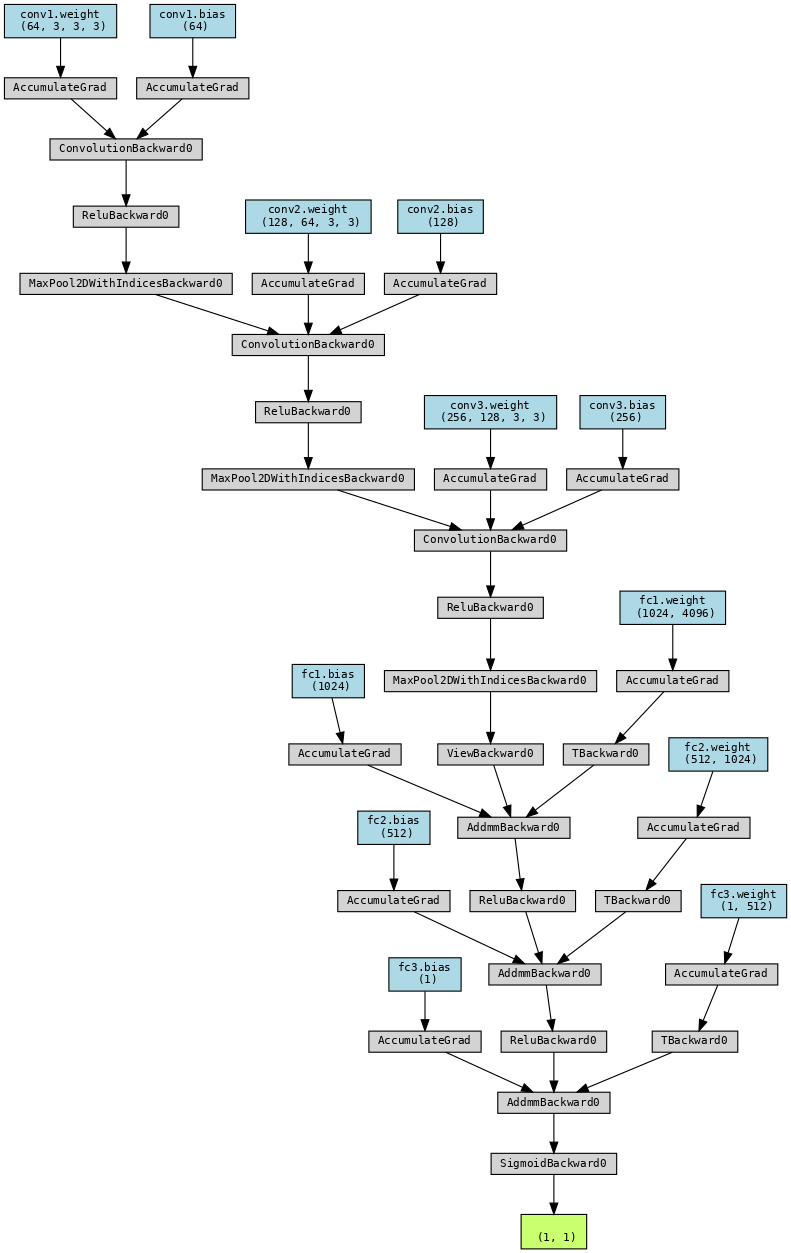

In [2]:
import os
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchviz import make_dot
from IPython.display import Image, display

# Define the CNN model
class BasicCNNNet(nn.Module):
    def __init__(self):
        super(BasicCNNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dummy input to infer the size of the output from conv layers
        self._to_linear = None
        self._dummy_input()

        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)

    def _dummy_input(self):
        x = torch.randn(1, 3, 50, 50)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        self._to_linear = x.view(-1).size(0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)  # Use sigmoid for binary classification
        return x

# Initialize the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BasicCNNNet().to(device)

# Create a dummy input tensor with the correct size (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 50, 50).to(device)

# Perform a forward pass to visualize the computation graph
output = net(dummy_input)

# Use torchviz to visualize the computation graph
dot = make_dot(output, params=dict(net.named_parameters()))
dot.format = 'png'
dot.render('BasicCNNNet')

# Display the image in the notebook
display(Image(filename='BasicCNNNet.png'))


Download dataset from https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images and clean as bellow.

In [17]:
import os
import shutil
from collections import Counter
import numpy as np
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Define the path to the dataset and the path to save the clean dataset
image_folders = "./DataSet/archive"
clean_dataset_path = "./DataSet/clean_archive"

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

# Ensure target labels are binary and of type Float
def check_labels(targets):
    targets = np.array(targets)
    unique_targets = np.unique(targets)
    return set(unique_targets).issubset({0, 1})

# Load images into a list of datasets and create a mask for valid datasets
valid_datasets = []

for file in os.listdir(image_folders):
    dataset_path = os.path.join(image_folders, file)
    try:
        dataset = ImageFolder(dataset_path, transform=transform)
        if check_labels(dataset.targets):
            valid_datasets.append((dataset_path, dataset))
            print(f"Loaded {len(dataset)} images from {file} with classes {dataset.classes}")
        else:
            print(f"Non-binary labels found in dataset {file}: {np.unique(dataset.targets)}")
    except Exception as e:
        print(f"Error loading {file}: {e}")


Loaded 219 images from 9174 with classes ['0', '1']
Loaded 878 images from 10274 with classes ['0', '1']
Loaded 1457 images from 13613 with classes ['0', '1']
Loaded 355 images from 13617 with classes ['0', '1']
Loaded 1290 images from 16166 with classes ['0', '1']
Loaded 507 images from 12896 with classes ['0', '1']
Loaded 1103 images from 9177 with classes ['0', '1']
Loaded 187 images from 16552 with classes ['0', '1']
Loaded 635 images from 10257 with classes ['0', '1']
Loaded 707 images from 12824 with classes ['0', '1']
Loaded 362 images from 9260 with classes ['0', '1']
Loaded 410 images from 9347 with classes ['0', '1']
Loaded 1326 images from 9381 with classes ['0', '1']
Loaded 366 images from 12748 with classes ['0', '1']
Loaded 1633 images from 13916 with classes ['0', '1']
Loaded 468 images from 10256 with classes ['0', '1']
Loaded 1045 images from 9176 with classes ['0', '1']
Loaded 571 images from 9083 with classes ['0', '1']
Loaded 1230 images from 13694 with classes ['0'

In [18]:
# Function to copy valid images to the new directory
def copy_valid_images(valid_datasets, clean_path):
    if not os.path.exists(clean_path):
        os.makedirs(clean_path)
    for dataset_path, dataset in valid_datasets:
        clean_folder = os.path.join(clean_path, os.path.basename(dataset_path))
        if not os.path.exists(clean_folder):
            os.makedirs(clean_folder)
        for class_idx in dataset.class_to_idx.values():
            class_folder = os.path.join(clean_folder, str(class_idx))
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)
        for sample, target in dataset.samples:
            shutil.copy(sample, os.path.join(clean_folder, str(target), os.path.basename(sample)))
        print(f"Copied images from {os.path.basename(dataset_path)} to {clean_folder}")

# Copy valid images to the new directory
copy_valid_images(valid_datasets, clean_dataset_path)

# Load images into a list of datasets from the cleaned directory
cleaned_images = []
for file in os.listdir(clean_dataset_path):
    dataset_path = os.path.join(clean_dataset_path, file)
    try:
        dataset = ImageFolder(dataset_path, transform=transform)
        if len(dataset.classes) > 0:
            cleaned_images.append(dataset)
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Ensure there are valid datasets left after filtering
if len(cleaned_images) == 0:
    raise ValueError("No valid datasets found after filtering.")

# Concatenate all the datasets into one
cleaned_datasets = torch.utils.data.ConcatDataset(cleaned_images)

# Verify that all labels are either 0 or 1
all_labels = torch.cat([torch.tensor(dataset.targets) for dataset in cleaned_datasets.datasets])
unique_labels = torch.unique(all_labels)
print(f"Unique labels in combined dataset: {unique_labels}")
assert torch.all((unique_labels == 0) | (unique_labels == 1)), "Found non-binary labels"

# Count the total number of images for each class
result = Counter(all_labels.numpy())

print(f"""Total Number of Images for each Class:
    Class 0 (No Breast Cancer): {result[0.0]}
    Class 1 (Breast Cancer present): {result[1.0]}""")


Copied images from 9174 to ./DataSet/clean_archive/9174
Copied images from 10274 to ./DataSet/clean_archive/10274
Copied images from 13613 to ./DataSet/clean_archive/13613
Copied images from 13617 to ./DataSet/clean_archive/13617
Copied images from 16166 to ./DataSet/clean_archive/16166
Copied images from 12896 to ./DataSet/clean_archive/12896
Copied images from 9177 to ./DataSet/clean_archive/9177
Copied images from 16552 to ./DataSet/clean_archive/16552
Copied images from 10257 to ./DataSet/clean_archive/10257
Copied images from 12824 to ./DataSet/clean_archive/12824
Copied images from 9260 to ./DataSet/clean_archive/9260
Copied images from 9347 to ./DataSet/clean_archive/9347
Copied images from 9381 to ./DataSet/clean_archive/9381
Copied images from 12748 to ./DataSet/clean_archive/12748
Copied images from 13916 to ./DataSet/clean_archive/13916
Copied images from 10256 to ./DataSet/clean_archive/10256
Copied images from 9176 to ./DataSet/clean_archive/9176
Copied images from 9083 to

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchmetrics
from torch.cuda.amp import autocast, GradScaler
from collections import Counter

# Define the CNN model
class BasicCNNNet(nn.Module):
    def __init__(self):
        super(BasicCNNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)

        # Dummy input to infer the size of the output from conv layers
        self._to_linear = None
        self._dummy_input()

        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)

    def _dummy_input(self):
        x = torch.randn(1, 3, 50, 50)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        self._to_linear = x.view(-1).size(0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the path to the cleaned dataset
clean_image_folders = "./DataSet/clean_archive"

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

# Load images into a list of datasets from the cleaned directory
cleaned_images = []
for file in os.listdir(clean_image_folders):
    dataset_path = os.path.join(clean_image_folders, file)
    try:
        dataset = ImageFolder(dataset_path, transform=transform)
        cleaned_images.append(dataset)
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Concatenate all the datasets into one
cleaned_datasets = torch.utils.data.ConcatDataset(cleaned_images)

# Verify that all labels are either 0 or 1
all_labels = torch.cat([torch.tensor(dataset.targets) for dataset in cleaned_datasets.datasets])
unique_labels = torch.unique(all_labels)
print(f"Unique labels in combined dataset: {unique_labels}")
assert torch.all((unique_labels == 0) | (unique_labels == 1)), "Found non-binary labels"

# Count the total number of images for each class
result = Counter(all_labels.numpy())
print(f"Total Number of Images for each Class:\n    Class 0 (No Breast Cancer): {result[0.0]}\n    Class 1 (Breast Cancer present): {result[1.0]}")

# Set random seed for reproducibility
random_seed = 1979
torch.manual_seed(random_seed)

# Determine the sizes of the training and testing sets
test_size = int(0.25 * (result[0.0] + result[1.0]))
train_size = len(cleaned_datasets) - test_size

# Split the datasets into training and testing sets
train_dataset, test_dataset = random_split(cleaned_datasets, [train_size, test_size])

# Create data loaders for the training and testing sets
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Initialize the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BasicCNNNet().to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

# Metrics
train_accuracy = torchmetrics.Accuracy(task="binary").to(device)
train_precision = torchmetrics.Precision(task="binary").to(device)
train_recall = torchmetrics.Recall(task="binary").to(device)
train_f1 = torchmetrics.F1Score(task="binary").to(device)

val_accuracy = torchmetrics.Accuracy(task="binary").to(device)
val_precision = torchmetrics.Precision(task="binary").to(device)
val_recall = torchmetrics.Recall(task="binary").to(device)
val_f1 = torchmetrics.F1Score(task="binary").to(device)

# Training parameters
num_steps = 2000
val_every_step = 50
step = 0
interrupted = False

# Lists to store metrics for averaging
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []

# Training loop
while step < num_steps and not interrupted:
    net.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        with autocast():
            outputs = net(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_losses.append(loss.item())
        train_accuracies.append(train_accuracy(outputs, labels.int()).item())
        train_precisions.append(train_precision(outputs, labels.int()).item())
        train_recalls.append(train_recall(outputs, labels.int()).item())
        train_f1_scores.append(train_f1(outputs, labels.int()).item())

        if (step + 1) % val_every_step == 0:
            net.eval()
            val_loss = 0
            val_accuracies = []
            val_precisions = []
            val_recalls = []
            val_f1_scores = []
            with torch.no_grad():
                for val_inputs, val_labels in testloader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device).float().unsqueeze(1)
                    with autocast():
                        val_outputs = net(val_inputs)
                        val_loss += criterion(val_outputs, val_labels).item()
                        val_accuracies.append(val_accuracy(val_outputs, val_labels.int()).item())
                        val_precisions.append(val_precision(val_outputs, val_labels.int()).item())
                        val_recalls.append(val_recall(val_outputs, val_labels.int()).item())
                        val_f1_scores.append(val_f1(val_outputs, val_labels.int()).item())

            avg_train_loss = sum(train_losses) / len(train_losses)
            avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
            avg_train_precision = sum(train_precisions) / len(train_precisions)
            avg_train_recall = sum(train_recalls) / len(train_recalls)
            avg_train_f1 = sum(train_f1_scores) / len(train_f1_scores)

            avg_val_loss = val_loss / len(testloader)
            avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
            avg_val_precision = sum(val_precisions) / len(val_precisions)
            avg_val_recall = sum(val_recalls) / len(val_recalls)
            avg_val_f1 = sum(val_f1_scores) / len(val_f1_scores)

            print(f"\nStep [{step + 1}/{num_steps}]: Train Loss: {avg_train_loss:.4f}, "
                  f"Train Accuracy: {avg_train_accuracy:.4f}, "
                  f"Train Precision: {avg_train_precision:.4f}, "
                  f"Train Recall: {avg_train_recall:.4f}, "
                  f"Train F1 Score: {avg_train_f1:.4f}")

            print(f"Validation Loss: {avg_val_loss:.4f}, "
                  f"Validation Accuracy: {avg_val_accuracy:.4f}, "
                  f"Validation Precision: {avg_val_precision:.4f}, "
                  f"Validation Recall: {avg_val_recall:.4f}, "
                  f"Validation F1 Score: {avg_val_f1:.4f}")

            # Reset metrics
            train_losses = []
            train_accuracies = []
            train_precisions = []
            train_recalls = []
            train_f1_scores = []

            net.train()

        step += 1

        if step >= num_steps:
            break


Unique labels in combined dataset: tensor([0, 1])
Total Number of Images for each Class:
    Class 0 (No Breast Cancer): 198738
    Class 1 (Breast Cancer present): 78786

Step [50/2000]: Train Loss: 0.6118, Train Accuracy: 0.7102, Train Precision: 0.0000, Train Recall: 0.0000, Train F1 Score: 0.0000
Validation Loss: 0.5209, Validation Accuracy: 0.7169, Validation Precision: 0.0000, Validation Recall: 0.0000, Validation F1 Score: 0.0000

Step [100/2000]: Train Loss: 0.4754, Train Accuracy: 0.7762, Train Precision: 0.5749, Train Recall: 0.3737, Train F1 Score: 0.4351
Validation Loss: 0.4274, Validation Accuracy: 0.8281, Validation Precision: 0.7075, Validation Recall: 0.6712, Validation F1 Score: 0.6824

Step [150/2000]: Train Loss: 0.4298, Train Accuracy: 0.8103, Train Precision: 0.7374, Train Recall: 0.5465, Train F1 Score: 0.6090
Validation Loss: 0.4016, Validation Accuracy: 0.8286, Validation Precision: 0.7214, Validation Recall: 0.6438, Validation F1 Score: 0.6737

Step [200/2000]:

KeyboardInterrupt: 

You can continue training as you wish.